### Question: Does Clauset's method independently verify $M_z$?

We've established in another notebook that two metrics, the chi-square and SSI both pick $M_z$ from the space of possibilities as the best choice of sample size to arrive at the 2, 6, 12, 20, ... inverse pattern for n-legomena. These tests pick the _same_ $M_z$ as optimally fitting the TTR curve, but they both feel rather "ad hoc". After all, the 2-6-12-20-etc pattern is a secondary prediction of a Perfect Zipf Distribution, so testing for that doesn't exactly rule out confounding factors. What we'd like to do here is assert, using [Clauset's method](https://arxiv.org/pdf/0706.1062.pdf), that of the space of possible sample sizes $[0, M]$ that either:

- (a) $M_z$ is the sample size most closely power-law-distributed with parameter $\alpha = 1$ OR
- (b) $M_z$ is the sample size most closely power-law-distributed, period.

Should this be the case, should we find a "spike" or a "well" in the signal at this spot, then combined with the other two signals, this provides some pretty strong evidence that something magical happens at this point.

In [16]:
# bloody dependencies
import matplotlib.pyplot as plt
from nltk.corpus import gutenberg
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as MSE
from scipy.special import zeta, zetac
from scipy.optimize import fsolve

# custom classes
from legomena import Corpus, SPGC

In [2]:
# standard project gutenberg corpus
spgc = SPGC.getMeta()

# for now, restrict study to english-only
spgc = spgc[spgc.language == "['en']"]

# preview
spgc.head()

,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
id,,,,,,,,
1,The Declaration of Independence of the United ...,"Jefferson, Thomas",1743.0,1826.0,['en'],604.0,"{'United States -- History -- Revolution, 1775...",Text
2,The United States Bill of Rights: The Ten Orig...,United States,NaN,NaN,['en'],158.0,"{'Civil rights -- United States -- Sources', '...",Text
3,John F. Kennedy's Inaugural Address,"Kennedy, John F. (John Fitzgerald)",1917.0,1963.0,['en'],28.0,{'Presidents -- United States -- Inaugural add...,Text
4,Lincoln's Gettysburg Address: Given November 1...,"Lincoln, Abraham",1809.0,1865.0,['en'],55.0,{'Consecration of cemeteries -- Pennsylvania -...,Text
5,The United States Constitution,United States,NaN,NaN,['en'],226.0,"{'United States. Constitution', 'United States...",Text


### Choosing a Book

Select a book for use as our fitting corpus.

Number of tokens (<corpus>.M): 210258
Number of types  (<corpus>.N): 16402
Legomena vector  (<corpus>.k): [   0 7197 2781 1555  872  632  439  338  303]
Frequency distribution accessible as <corpus>.fdist
Type-Token Relation data accessible as <corpus>.TTR
Log model accessible as <corpus>.M_z, .N_z
Optimum (M_z,N_z) = (114555, 12324)


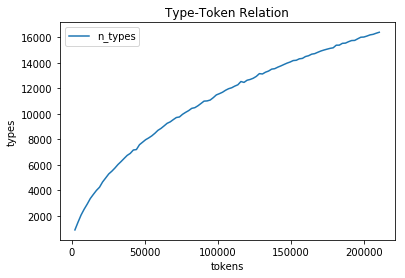

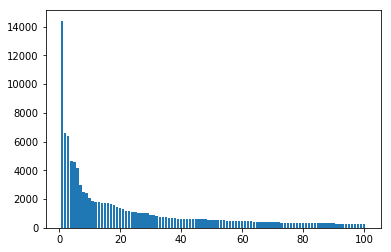

In [3]:
# spgc[spgc.title.str.contains("Bible", na = False)].head()

# moby dick
corpus = SPGC.get(2701)
df = corpus.buildTTRCurve()
M_z, N_z = corpus.fit(optimize = True)
print("Optimum (M_z,N_z) =", (M_z, N_z))

# plot TTR curve
plt.plot(df.m_tokens, df.n_types)
plt.title("Type-Token Relation")
plt.xlabel("tokens")
plt.ylabel("types")
plt.legend()
plt.show()

# plot WFD
xmax = 50
df = corpus.fdist.copy().head(xmax)
plt.bar(df["rank"], df["freq"])
plt.show()

## Fake Zipfian Data

Here we take a brief vacation from our words data and instead use `numpy.random.zipf()` to generate some fake data instead. Indeed, it exhibits exactly the same pattern, bottoming out at a value somewhere around $\alpha = 1.75$.

In [4]:
from scipy.stats import chisquare
def ssi_test(f_obs, f_exp):
    assert all(f_obs >= 0)
    assert all(f_exp >= 0)
    nonzero = (f_obs > 0) & (f_exp > 0)
    f_obs = f_obs[nonzero]
    f_exp = f_exp[nonzero]
    f_obs = f_obs / f_obs.sum()
    f_exp = f_exp / f_exp.sum()
    return np.sum((f_obs - f_exp) * np.log(f_obs / f_exp))

M, n = 9999, 40
f_exp = M * np.array([1 / i / (i+1) for i in range(1, n) ])
f_exp
df = []
for _ in range(99):
    alpha = np.random.uniform(1.2, 2.5)
    x = np.random.zipf(a = alpha, size = M)
    f_obs = np.array([ sum(x == i) for i in range(1, n)])
    sse = np.sum((f_exp - f_obs)**2)
    ssi = ssi_test(f_obs, f_exp)
    chi2 = chisquare(f_obs, f_exp)
    df.append((alpha, sse, ssi, chi2.statistic, chi2.pvalue))
    
df = pd.DataFrame(df, columns = ["alpha", "sse", "ssi", "chi2", "chi2p"])
df.head()

,alpha,sse,ssi,chi2,chi2p
0,1.412465,3.124324e+06,0.123330,1470.079105,3.753034e-284
1,1.472703,1.870142e+06,0.084126,1079.065804,1.170920e-201
2,2.306454,4.253155e+06,0.196663,1653.152213,0.000000e+00
3,1.329745,5.598400e+06,0.201198,2263.336031,0.000000e+00
4,1.430407,2.776276e+06,0.118188,1413.623260,3.372264e-272


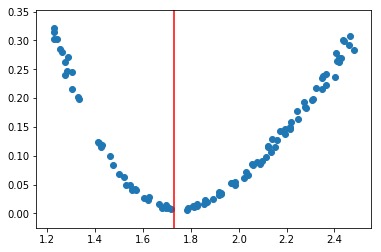

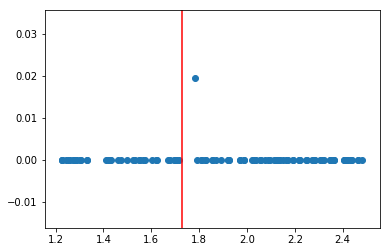

In [7]:
plt.scatter(df.alpha, df.ssi)
plt.axvline(x = B, color = 'r')
plt.show()

plt.scatter(df.alpha, df.chi2p)
plt.axvline(x = B, color = 'r')
plt.show()

## Enter Number Theory

For whatever reason (cite), $x^{\alpha} \approx x(x+1)$ for $\alpha = \zeta^{-1}(2)$, a constant we'll call $\beta$ or $\alpha_{opt}$.

In [68]:
# solve for \zeta(B) = 2
func = lambda x : zeta(x) - 2.
x0 = 1.75
B = fsolve(func, x0)[0]
B

print("B = ", B)
print("zeta(B) =", zeta(B))

B =  1.7286472389981835
zeta(B) = 2.0000000000000004


In fact, we can count hapaxes and higher $n$-legomena straight from this fake distribution, just by answering the question, what is $P(x = n)$ given $p(x) = \frac{x^{-\alpha}}{\zeta(\alpha)}$?

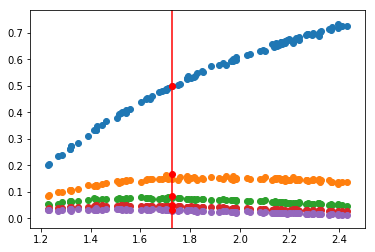

,alpha,hapax,dis,tris,tetra,penta
12,1.750991,0.504350,0.145715,0.078508,0.048305,0.028503
82,1.758007,0.506051,0.155416,0.076208,0.046305,0.032103
39,1.786346,0.530553,0.147215,0.073007,0.041904,0.033003
94,1.788966,0.526553,0.158416,0.072207,0.043904,0.028403
1,1.790833,0.535454,0.144914,0.071207,0.043504,0.032103


In [9]:
# count hapaxes from 3rd party zipf distribution
M, n = 9999, 9
df = []
for _ in range(99):
    alpha = np.random.uniform(1.2, 2.5)
    x = np.random.zipf(a = alpha, size = M)
    f_obs = np.array([ sum(x == i) for i in range(n)]) / M
    df.append((alpha, f_obs[1], f_obs[2], f_obs[3], f_obs[4], f_obs[5]))
    
df = pd.DataFrame(df, columns = ["alpha", "hapax", "dis", "tris", "tetra", "penta"])
df = df.sort_values("alpha")
df.head()

plt.scatter(df.alpha, df.hapax)
plt.scatter(df.alpha, df.dis)
plt.scatter(df.alpha, df.tris)
plt.scatter(df.alpha, df.tetra)
plt.scatter(df.alpha, df.penta)
plt.axvline(x = B, color = 'r')
plt.scatter([B, B, B, B, B], 1./np.array([2,6,12,20,30]), color = 'r')
plt.show()

df[df.alpha > B].head()

Number of tokens (<corpus>.M): 114555
Number of types  (<corpus>.N): 12330
Legomena vector  (<corpus>.k): [   0 6101 2084 1075  632  436  304  253  171]
Frequency distribution accessible as <corpus>.fdist


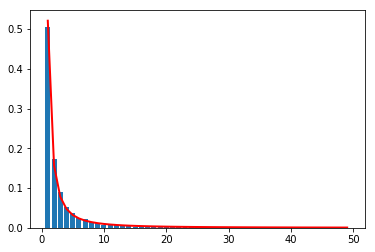

In [42]:
tokens = np.random.choice(corpus.tokens, corpus.M_z, replace = False)
minicorpus = Corpus(tokens)

s = minicorpus.k # np.random.zipf(B, 1000)

x = np.arange(1., 50.)
y = 1./x**B

plt.bar(x, s[1:50]/sum(s[1:50]))
plt.plot(x, y/sum(y), linewidth=2, color='r')
plt.show()

In [ ]:
import powerlaw

data = minicorpus.fdist.freq.values
dist = powerlaw.Fit(data).power_law
a_obs = dist.alpha
a_opt = B

x = np.arange(1, 50)
y = np.random.zipf(B, 9999)
_, y = np.unique(y, return_counts = True) # group
y = y / sum(y) # normalize

y1 = 1/x/(x+1)               # model 1: k_n ~ 1/n/(n+1)
y2 = x**-a_obs / zeta(a_obs) # clauset: a ~ 2.09
y3 = x**-a_opt / zeta(a_opt) # theory: a = B ~ 1.72

plt.scatter(x, y, color = 'r')
plt.plot(x, y_, label = "poly")
plt.plot(x, y2, label = f"clauset (a = {a_obs:0.4f})")
plt.plot(x, y3, label = f"theory  (a = {a_opt:0.4f})")
plt.loglog()
plt.title(f"Moby Dick n-Legomena Frequencies")
plt.legend()
plt.show()

Calculating best minimal value for power law fit
/home/victor/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


Calculating best minimal value for power law fit
/home/victor/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


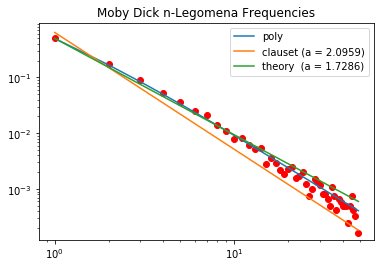

In [70]:
import powerlaw

data = minicorpus.fdist.freq.values
dist = powerlaw.Fit(data).power_law
a_obs = dist.alpha
a_opt = B

x = np.arange(1, 50)
y = minicorpus.k[1:50]
y = y / sum(y) # normalize

y1 = 1/x/(x+1)               # model 1: k_n ~ 1/n/(n+1)
y2 = x**-a_obs / zeta(a_obs) # clauset: a ~ 2.09
y3 = x**-a_opt / zeta(a_opt) # theory: a = B ~ 1.72

plt.scatter(x, y, color = 'r')
plt.plot(x, y_, label = "poly")
plt.plot(x, y2, label = f"clauset (a = {a_obs:0.4f})")
plt.plot(x, y3, label = f"theory  (a = {a_opt:0.4f})")
plt.loglog()
plt.title(f"Moby Dick n-Legomena Frequencies")
plt.legend()
plt.show()